In [37]:
%pylab inline
import csv
import itertools
import pandas as pd
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [38]:
trips = pd.read_csv("../GTFS_DATA/torino_it/trips.txt",header = 0)
stop_times = pd.read_csv("../GTFS_DATA/torino_it/stop_times.txt", header = 0)
stops = pd.read_csv("../GTFS_DATA/torino_it/stops.txt",header = 0)
calendar_dates = pd.read_csv("../GTFS_DATA/torino_it/calendar_dates.txt",header=0)

In [39]:
route_trip_dict={} # dizionario route -> trip
trip_route_dict={} # dizionario trip -> route
for route, group in trips.groupby('route_id'):
    route_trip_dict[route] = group['trip_id']
trip_route_dict=dict(zip(trips['trip_id'],trips['route_id']))

In [40]:
class stop:
    def __init__ (self, id, code,name, lat, lon):
        self.name = name
        self.code = code
        self.id = id
        self.lat = lat
        self.lon = lon

In [41]:
class itin:
    def __init__(self, id, stop_list, tempo, frequenze):
        self.id = id
        self.stop_list = stop_list
        self.tempo = tempo
        self.frequenze = frequenze

Nel box seguente creo una lista di fermate, definite come oggetti con tutte le caratteristiche descritte nella classe definita sopra

In [42]:
stop_list=[]
i=0
for a in stops.iterrows():
    if isnan(a[1]['stop_code']): #alcune fermate hanno stop_code nullo, glie ne mettiamo uno unico noi
        code = 10002 + i
        i = i + 1
    else:
        code = int(a[1]['stop_code'])
    stop_list.append(stop
                     (int(a[1]['stop_id']),
                      code,
                      str(a[1]['stop_name']),
                      float(a[1]['stop_lat']),
                      float(a[1]['stop_lon'])))

In [43]:
trip_itinerario = {} #per ogni trip, l'itinerario seguito
print "trip incompleti:"
for trip, group in stop_times.groupby('trip_id'):#tanti dataframe, ognuno ha il suo trip_id
    #print group, type(list(group['stop_id'])), type(list(group['stop_id'])[0]),list(group['stop_id'])[0]
    #break
    if len(group)== max(group['stop_sequence']):#controllo itinerari incompleti (non aggiunti al dizionario)
        trip_itinerario[trip]=list(group.sort_values('stop_sequence')['stop_id'].values)
    else:
        print trip
#qui creo un dizionario che associa ad ogni trip la lista di stop_id che lo costituisce

itin_trip = defaultdict(list) #per ogni itinerario, i trip con quell'itinerario
for key, value in sorted(trip_itinerario.iteritems()):
    itin_trip[str(value)].append(key)

trip incompleti:
2986
2987
4761
4762


In [44]:
# mi serve l'ora di arrivo per ogni trip e l'orario di partenza, dividendo per il numero di fermate 
# ho l'orario per ogni fermata. Codice di esempio per spiegare quello che abbiamo fatto
#print itin_trip.keys()[0]
tripp = itin_trip[itin_trip.keys()[1]][0]
print tripp
selezione = stop_times[stop_times['trip_id']==tripp] # le stop sequence con quel trip_id
#print selezione
#print selezione['stop_sequence']
lunghezza = max(selezione['stop_sequence'])
fine = selezione[selezione['stop_sequence'] == max(selezione['stop_sequence'])]
inizio = selezione[selezione['stop_sequence'] == 1]

stringa_fine = str(fine['arrival_time']).split()[1].split(':')
stringa_inizio = str(inizio['arrival_time']).split()[1].split(':')
minuto_fine = 60*(int(stringa_fine[0])% 24)+int(stringa_fine[1])
minuto_inizio = 60*(int(stringa_inizio[0])% 24)+int(stringa_inizio[1]) 
print minuto_fine - minuto_inizio

25257
39


0.58814229249


(array([  17.,    1.,    2.,    0.,    0.,   26.,   25.,    4.,    1.,
           0.,    0.,    0.,    2.,    0.,    4.,   11.,    0.,    0.,
           1.,    5.,    1.,    0.,    0.,    3.,    0.,    1.,    0.,
           2.,    0.,    0.,    0.,    0.,    4.,    0.,  129.,    4.,
         116.,    3.,    1.,    0.,    0.,   67.,    3.,    3.,   87.,
           1.,    0.,    0.,    2.,   12.,    1.,    0.,    4.,    4.,
           0.,    2.,    0.,    1.,    0.,    0.,    1.,    2.,    0.,
           4.,    0.,    0.,    1.,    0.,    0.,    0.,   14.,    0.,
           4.,    0.,   24.,   15.,    0.,    4.,    0.,    1.,   33.,
          12.,    1.,    7.,    3.,   16.,    0.,    6.,    1.,   23.,
          12.,    0.,    1.,    1.,    2.,    0.,    1.,    0.,    2.,    3.]),
 array([   3.  ,    4.77,    6.54,    8.31,   10.08,   11.85,   13.62,
          15.39,   17.16,   18.93,   20.7 ,   22.47,   24.24,   26.01,
          27.78,   29.55,   31.32,   33.09,   34.86,   36.63,   38.4

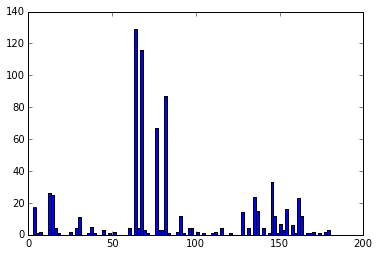

In [60]:
# qui devo assegnare ad ogni itinerario partenza e arrivo
# servono trip_mol e gli stop_times
# dizionario service_id -> molteplicità servizio
service_id_molt = {}
for service_id, group in calendar_dates.groupby('service_id'):
    service_id_molt[service_id] =len(group)
trip_mult=dict(zip(trips['trip_id'],trips['service_id']))
for key,value in trip_mult.iteritems():
    trip_mult[key]=service_id_molt[value]

itin_freq = {}
for itin,tripos in itin_trip.iteritems():
    itin_freq[itin] = 0
    for trip in tripos:
        itin_freq[itin] = itin_freq[itin] + trip_mult[trip]

data = [i for i in itin_freq.values() if i < 190]
print float(len(data))/float(len(itin_freq)) 
#itinerari con un numero sospettosamente basso di molteplicità (95 giorni), ma ricordiamo che stiamo ancora considerando
#la totalità dei viaggi, anche su rete extraurbana
plt.hist(data, bins =100)

In [96]:
itinero = itin_trip.keys()[1]  #itinerario di prova
orari = [0 for i in range(24)] #
for tripso in itin_trip[itinero]:
    selezione = stop_times[stop_times['trip_id']== tripso]
    ora_arrivo = selezione[selezione['stop_sequence']==max(selezione['stop_sequence'])]['arrival_time']#.split(':')
#   print ora_arrivo
    ora_arrivo = str(ora_arrivo).split()[1].split(':')
    min_arrivo = ora_arrivo[1]
    ora_arrivo = ora_arrivo[0]
    print ora_arrivo
    orari[int(ora_arrivo)] +=1
    
print orari


21
21
18
16
19
14
18
17
15
20
18
15
17
20
14
16
17
19
16
15
20
18
17
19
16
16
19
14
18
17
18
20
15
18
15
20
17
19
14
17
16
16
15
20
18
19
16
17
14
20
20
14
21
25


IndexError: list index out of range

In [20]:
itin_list = []
i=0
for key,value in itin_trip.iteritems():
    id = i
    i += 1
    lista_stop = (key.strip('[]').split(', ')[0])
    break
    

54228001
